In [1]:
import os

from pydantic import BaseModel, Field
from IPython.display import Image, display
from typing import Annotated, TypedDict, List

from langchain_openai import ChatOpenAI

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [2]:
from dotenv import load_dotenv

load_dotenv("/home/ubuntu/LLM-tutorials/keys.env")

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
ANTHROPIC_API_KEY = os.getenv("ANTHROPIC_API_KEY")

LANGSMITH_API_KEY = os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = LANGSMITH_API_KEY

## State 정의

In [3]:
"""
Annotated는 타입힌트에 메타데이터(추가정보)를 포함시킬 수 있게 함.

    from typing import Annotated
    변수명: Annotated[기본타입, 메타데이터1, 메타데이터2, ...]


"""

class Employee(BaseModel):
    ## Pydantic의 Field와 Annotated를 사용하면 모델에 대한 유효성 검사를 설정할 수 있음.
    id: Annotated[int, Field(..., description="직원 ID")] 
    name: Annotated[str, Field(..., min_length=3, max_length=50, description="이름")]
    age: Annotated[int, Field(gt=18, lt=65, description="나이 (19-64세)")]
    salary: Annotated[float, Field(gt=0, lt=10000, description="연봉 (단위: 만원, 최대 10억)")]
    skills: Annotated[List[str], Field(min_items=1, max_items=10, description="보유 기술 (1-10개)")]


## langgraph에서는 Annotated를 사용해서 특정 필드에 대해 특정 동작을 하도록 할 수 있음.
## 아래 코드에서는 messages라는 필드에 대해 add_messages라는 함수를 적용하도록 함.
## 이를 통해 messages 필드는 add_messages 함수를 사용해 기존 메세지 리스트에 신규 메세지를 추가하는 방식으로 동작한다.
class State(TypedDict):
    messages: Annotated[list, add_messages]

## Node 정의

In [4]:
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

## llm은 Runnable 객체이므로 invoke, stream 등의 메서드를 통해 실행 가능.
## state["messages"]는 메세지 리스트이므로 llm에게 이전까지의 대화 리스트를 입력으로 전달하는셈.
## llm의 응답 메세지가 State의 messages 필드에 추가된다.(add_messages 함수 덕분)
def chatbot(state:State):
    return {"messages" : [llm.invoke(state["messages"])]}

## Graph 정의, 노드 추가

In [5]:
graph_bulder = StateGraph(State) ## 커스텀으로 정의한 State 클래스 객체를 그래프의 상태로 전달하고 그래프를 생성.
graph_bulder.add_node("chatbot", chatbot) ## chatbot 노드를 그래프에 추가.

## Edge 추가

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


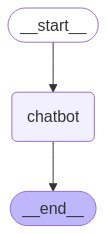

In [7]:
graph_bulder.add_edge(START, "chatbot")
graph_bulder.add_edge("chatbot", END)

graph = graph_bulder.compile() ## 그래프 컴파일

display(Image(graph.get_graph().draw_mermaid_png())) ## 그래프 시각화

In [9]:
question = "개발자가 해외 취업을 위해서 영어 공부를 하려고 토익이나 토플을 공부해야하니?? 뭐부터 시작해야할지 잘모르겠네..."

# 그래프 이벤트 스트리밍
for event in graph.stream({"messages": [("user", question)]}):
    # 이벤트 값 출력
    for value in event.values():
        print("Assistant:", value["messages"][-1].content)


Assistant: 해외 취업을 목표로 하는 개발자라면 영어 능력은 매우 중요합니다. 토익(TOEIC)과 토플(TOEFL)은 각각 다른 목적을 가지고 있으므로, 어떤 시험을 선택할지는 본인의 목표에 따라 달라질 수 있습니다.

1. **TOEIC**: 주로 비즈니스 영어 능력을 평가하는 시험입니다. 해외 기업에서 일할 때 필요한 실용적인 영어 능력을 측정합니다. 만약 영어로 된 이메일 작성, 회의 참석, 비즈니스 대화 등이 중요하다면 TOEIC이 유용할 수 있습니다.

2. **TOEFL**: 주로 학문적 영어 능력을 평가하는 시험입니다. 대학원 진학이나 영어를 사용하는 국가에서의 학업을 목표로 한다면 TOEFL이 더 적합합니다. 기술적인 문서나 연구 논문을 읽고 이해하는 능력이 중요하다면 TOEFL 준비가 필요할 수 있습니다.

### 시작하는 방법

1. **목표 설정**: 어떤 분야에서 일하고 싶은지, 어떤 영어 능력이 필요한지를 고려하여 TOEIC 또는 TOEFL 중 하나를 선택하세요.

2. **학습 계획 세우기**: 매일 일정 시간을 정해놓고 공부하는 것이 좋습니다. 어휘, 문법, 듣기, 말하기, 읽기, 쓰기 등 각 영역을 골고루 연습하세요.

3. **자료 활용**: 온라인 강의, 교재, 모의고사 등을 활용하여 실력을 쌓아가세요. 특히, 실제 시험과 유사한 환경에서 연습하는 것이 중요합니다.

4. **실전 경험 쌓기**: 영어로 대화할 기회를 많이 만들어보세요. 언어 교환 모임이나 온라인 커뮤니티에 참여하여 실제로 영어를 사용하는 경험을 쌓는 것이 좋습니다.

5. **피드백 받기**: 영어를 잘하는 친구나 튜터에게 피드백을 받아보세요. 자신의 약점을 파악하고 개선하는 데 도움이 됩니다.

결론적으로, 자신의 목표에 맞는 시험을 선택하고 체계적으로 준비하는 것이 중요합니다. 영어 실력을 향상시키는 과정에서 자신감을 얻고, 해외 취업에 한 걸음 더 가까워질 수 있을 것입니다.
